<a href="https://colab.research.google.com/github/Deare-stack/GenAI/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: GenAI Assignment 6

Your Name: Deare

Date: 2024/11/28

1. Data Preparation: Convert MIDI files into sequences of notes and durations.

In [ ]:
!apt-get install musescore### Install MuseScore to handle music notation
!apt-get install music21## Install music21, a toolkit for computer-aided musicology
!apt-get install fluidsynth### Install FluidSynth, a software synthesizer for generating audio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
musescore is already the newest version (2.3.2+dfsg4-15).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package music21
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

from transformer_utils import (
    parse_midi_files,
    load_parsed_files,
    get_midi_note,
    SinePositionEncoding,
)

In [ ]:
PARSE_MIDI_FILES = True## Flag to determine whether to parse MIDI files
PARSED_DATA_PATH = "/content/data/"
DATASET_REPETITIONS = 1### Number of times to repeat the dataset during training to enhance learning
# Length of the sequence to be used in the model
SEQ_LEN = 50
EMBEDDING_DIM = 256# Dimension of the embedding layer
KEY_DIM = 256# Dimension of keys in the attention mechanism
N_HEADS = 5# Number of attention heads in the transformer model
DROPOUT_RATE = 0.3# Rate of dropout to prevent overfitting
FEED_FORWARD_DIM = 256# Dimension of the feed-forward network in the transformer
LOAD_MODEL = False# Flag to determine whether to load a pre-trained model

# optimization
EPOCHS = 50# Number of training epochs
BATCH_SIZE = 256# Batch size for training

GENERATE_LEN = 50# Length of the music sequence to generate after training

In [ ]:
# Load the data
file_list = glob.glob("/content/data/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [ ]:
parser = music21.converter#handle parsing of music files

In [ ]:
example_score = (
    music21.converter.parse(file_list[14]).splitAtQuarterLength(12)[0].chordify()
)## # Parse the music file at index 14, # Split the score at 12th quarter length and select the first part and  Convert to chordify

In [ ]:
example_score.show("text")## Display the musical structure of the example_score

{0.0} <music21.metadata.Metadata object at 0x7f6eb2b2f730>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250>
    {0.0} <music21.key.Key of E- major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 3.5ql>
    {3.5} <music21.tempo.MetronomeMark Quarter=96>
    {3.5} <music21.chord.Chord B-3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord E-4>
    {0.5} <music21.chord.Chord D4>
    {0.75} <music21.chord.Chord C4>
    {1.0} <music21.chord.Chord B-3>
    {1.25} <music21.chord.Chord G#3>
    {1.5} <music21.chord.Chord G3>
    {1.75} <music21.chord.Chord G#3>
    {2.0} <music21.chord.Chord B-3>
    {2.25} <music21.chord.Chord G#3>
    {2.5} <music21.chord.Chord G3>
    {2.75} <music21.chord.Chord F3>
    {3.0} <music21.chord.Chord E-3>
   

In [ ]:
if PARSE_MIDI_FILES:## # Parse MIDI files using the specified parser, sequence length, and file path
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )###  file_list:List of MIDI files to parse.parser:# Parser object from music21.converter.  SEQ_LEN + 1: for next sequence generation
else:
    notes, durations = load_parsed_files()## # Load pre-parsed note and duration data if MIDI files do not need to be parsed

1 Parsing /content/data/cs2-6gig.mid


<ipython-input-15-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


735 notes parsed
2 Parsing /content/data/cs1-3cou.mid
1555 notes parsed
3 Parsing /content/data/cs6-5gav.mid
2361 notes parsed
4 Parsing /content/data/cs3-2all.mid
3098 notes parsed
5 Parsing /content/data/cs3-6gig.mid
4059 notes parsed
6 Parsing /content/data/cs4-1pre.mid
4876 notes parsed
7 Parsing /content/data/cs5-3cou.mid
5306 notes parsed
8 Parsing /content/data/cs2-1pre.mid
5944 notes parsed
9 Parsing /content/data/cs6-6gig.mid
7116 notes parsed
10 Parsing /content/data/cs2-2all.mid
7809 notes parsed
11 Parsing /content/data/cs4-6gig.mid
8780 notes parsed
12 Parsing /content/data/cs4-3cou.mid
9702 notes parsed
13 Parsing /content/data/cs4-5bou.mid
11026 notes parsed
14 Parsing /content/data/cs3-1pre.mid
12007 notes parsed
15 Parsing /content/data/cs4-2all.mid
13062 notes parsed
16 Parsing /content/data/cs3-5bou.mid
13943 notes parsed
17 Parsing /content/data/cs5-6gig.mid
14392 notes parsed
18 Parsing /content/data/cs6-4sar.mid
14727 notes parsed
19 Parsing /content/data/cs6-2all

In [ ]:
example_notes = notes[658]  # Get the element at index 658 from the notes list and store it in example_notes
example_durations = durations[658]  # Get the element at index 658 from the durations list and store it in example_durations

# Print the 658th element from the notes and durations lists
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")



Notes string
 G3 E3 D3 E3 F3 D3 G3 E3 D3 E3 F3 D3 G3 E3 C#3 B-3 A3 G3 F3 E3 F2 A3 G3 F3 E3 C#3 D3 B-2 A2 G2 A2 F2 D2 A2 D3 E3 F3 D3 E-3 F3 G3 E-3 F3 D3 G3 A3 B-3 G3 A3 F3 E-3 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


2. Tokenization: Convert the notes and durations into tokens that the Transformer model can understand.

In [ ]:
def create_dataset(elements):
    ds = (### Create a TensorFlow dataset from the input elements
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)### Batch the data with the specified batch size, dropping remainders
        .shuffle(1000)### Shuffle the dataset with a buffer size of 1000
    )# Set up a vectorization layer
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )# Adapt the vectorization layer to our dataset to build a vocabulary.
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab# Return the dataset along with its corresponding vectorization layer and vocabulary.

# Generate the datasets and vectorization layers for notes and durations, plus their vocabularies.
notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)##Combine the notes and durations into one dataset for processing at the same time.
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

2. Tokenization: Convert the notes and durations into tokens that the Transformer model can understand.

In [ ]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))### Print headers for the tokens for clarity in output.
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],### Convert to numpy array and slice the first 11 nodetes and duration
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")### Print each pair of note and duration tokens formatted to align in columns.

note token duration token
         2         2
         8         2
         4         2
         8         2
         5         2
         4         2
         2         2
         8         2
         4         2
         8         2
         5         2


In [ ]:
notes_vocab_size = len(notes_vocab)### Calculate the vocabulary sizes for notes and durations.
durations_vocab_size = len(durations_vocab)

## Output the size of the notes vocabulary and display the first 10 tokens:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")
# Output the size of the durations vocabulary and display the first 10 tokens
print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 1/6


4. Training: Train the model on the processed data to learn the relationships between notes, durations, and musical structure.

In [ ]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)### Tokenize notes and durations using the vectorization layers.
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])# Inputs for the model
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])# Corresponding targets
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [ ]:
example_input_output = ds.take(1).get_single_element()### Take a single example from the dataset to illustrate input-output structure
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[13,  2, 15, ...,  6, 16,  6],
       [ 2, 15,  2, ..., 16,  6, 15],
       [15,  2, 13, ...,  6, 15,  6],
       ...,
       [ 8,  4, 13, ..., 18, 16, 18],
       [ 4, 13,  5, ..., 16, 18,  4],
       [13,  5,  4, ..., 18,  4, 18]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 2, 15,  2, ..., 16,  6, 15],
       [15,  2, 13, ...,  6, 15,  6],
       [ 2, 13, 11, ..., 15,  6, 16],
       ...,
       [ 4, 13,  5, ..., 16, 18,  4],
       [13,  5,  4, ..., 18,  4, 18],
       [ 5,  4,  5, ...,  4, 18, 27]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,

Create the causal attention mask function

Goal of create casual mask is ensures that each part of a sequence can only be influenced by the parts that came before it, not by any future parts.

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]### Generate matrices for indexing destination and source positions
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest### Create the mask where each destination can only attend to earlier source positions
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

Create a Transformer Block layer

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)### Initialize transformer block parameters
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(### Attention mechanism with specified number of heads and dimensionality
            num_heads, key_dim, output_shape=embed_dim
        )### Dropout and layer normalization layers for the attention output
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")# Feed-forward network applied after attention
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)# Dropout and layer normalization layers for the feed-forward network output
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs) # Get input dimensions to create an appropriate causal attention mask
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(# Create a causal mask to ensure attention is only applied to previous tokens
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(# Apply multi-head attention with causal mask
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)# Apply the feed-forward network
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)# Final output with residual connection and layer normalization

    def get_config(self):
        config = super().get_config()
        config.update(# Serialize configuration to enable model saving and loading
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

Create the Token and Position Embedding

Combines tokens and psitioanal embeddings into one embedding, using both their identities and their order in a sequence to process ordered data.

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):##combining token and positional embeddings
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size### Total number of unique tokens
        self.embed_dim = embed_dim# Dimension of each token embedding
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

Generate and visualize token and positional embeddings for sequence data

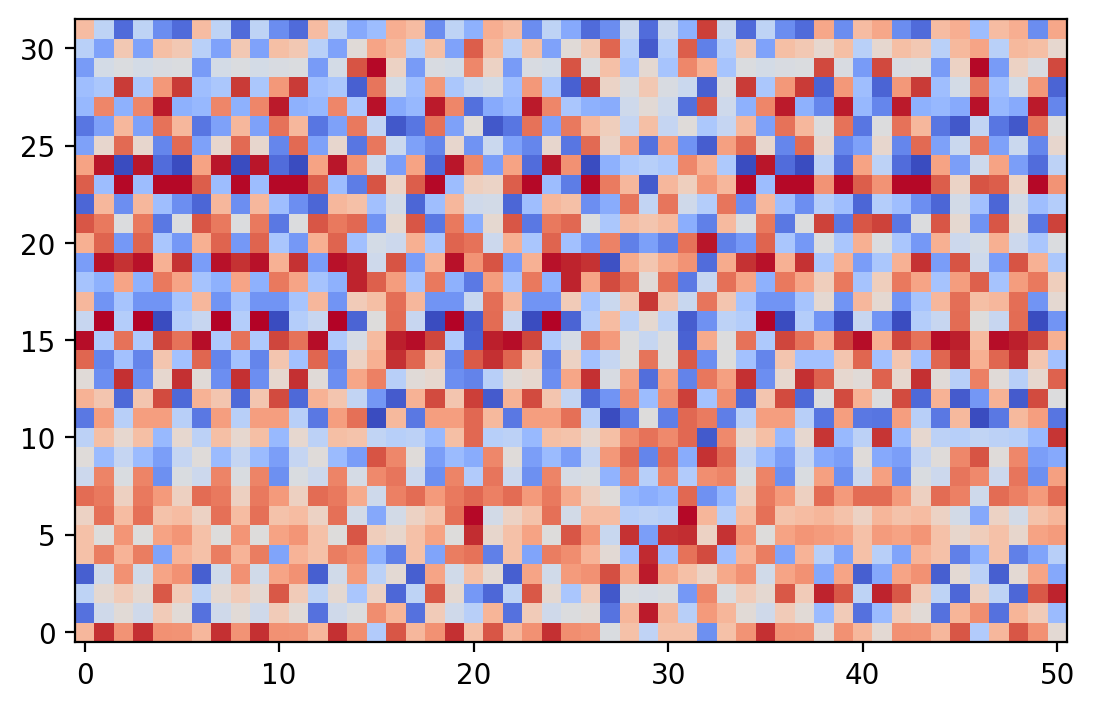

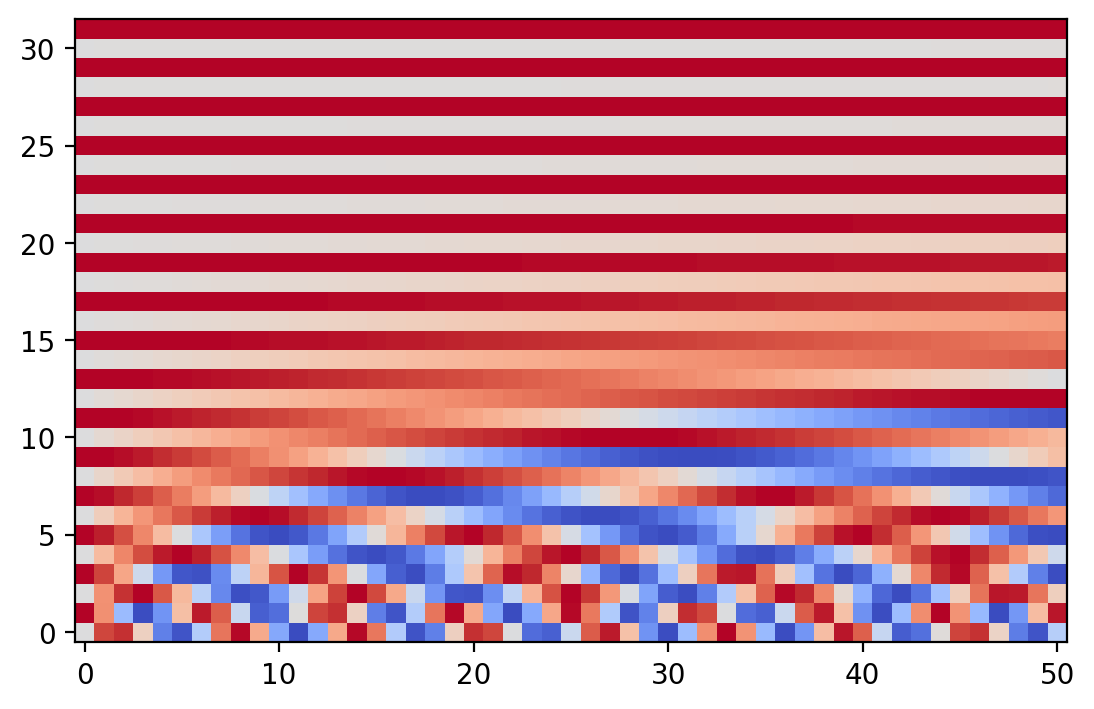

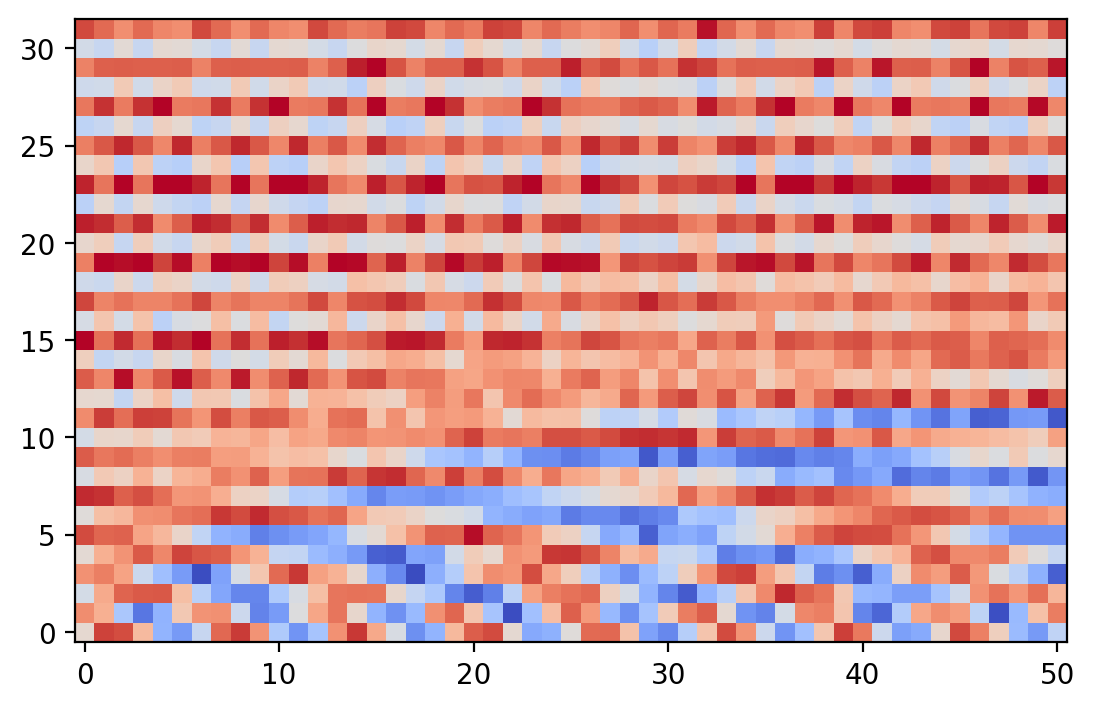

In [ ]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

3.Model Architecture: Build a Transformer-based architecture that processes musical notes and durations to generate new sequences.

Goal of this model: Predicts the next likely note and duration from sequences, based on previous notes and durations. the model trained using sparse categorical crossentropy.

(att_model) is also defined to specifically output the attention scores from the transformer block.

In [ ]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          7,552 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          3,072 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 59)       │         15,163 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 24)       │          6,168 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,479,379 (5.64 MB)

 Trainable params: 1,479,379 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

4.Training: Train the model on the processed data to learn the relationships between notes, durations, and musical structure.

Create a callback for model that generates music sequences at the end of each training epoch, saving them as MIDI files to monitor the model's progress in learning music generation.

In [ ]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        #midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [ ]:
# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

After each epoch, the model generates sequences of notes and durations.

The values 0.0, 0.5, and 1.0 represent the durations of musical notes.

0.0 generally means silence.
0.5: half a beat note.
1.0: one full beat note.

In [ ]:
model.fit(
    ds,
    epochs=50,
    callbacks=[
        music_generator,
    ],
)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - duration_outputs_loss: 1.5269 - loss: 5.1513 - note_outputs_loss: 3.6244

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


[['START', 'G3', 'C4', 'A3', 'F#4', 'G3', 'D3', 'G3', 'A4', 'C4', 'G3', 'F#3', 'G3', 'F3', 'G3', 'F3', 'D4', 'E3', 'F3', 'E-3', 'E-3', 'D3', 'E-3', 'D3', 'F3', 'D3', 'E-3', 'F3', 'F3', 'B-3', 'B-3', 'F3', 'D3', 'E-3', 'E-3', 'F3', 'C3', 'D3', 'G3', 'F3', 'E-3', 'E-3', 'F3', 'D3', 'E-3', 'E-3', 'F3', 'G3', 'F3'], ['0.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]
107/107 ━━━━━━━━━━━━━━━━━━━━ 100s 843ms/step - duration_outputs_loss: 1.5228 - loss: 5.1452 - note_outputs_loss: 3.6223
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - duration_outputs_loss: 0.6695 - loss: 3.6069 - note_outputs_loss: 2.9374[['START', 'A3', 'G3', 'F3', 'C3', 'D3', 'E3', 'F3', 'E3', 'E3', 'F3', 'D3', 'E3', 'D3', 'C3',

[['START', 'F:major', '3/4TS', 'rest', 'G3', 'B3', 'G#3', 'B3', 'A3', 'G#3', 'F#3', 'E3', 'G#3', 'F#3', 'G#3', 'A3', 'G#3', 'F#3', 'E3', 'D3', 'C3', 'E3', 'F#3', 'G#3', 'A3', 'B3', 'G#3', 'A3', 'G#3', 'A3', 'G#3', 'A3', 'B3', 'G#3', 'A3', 'G#3', 'F#3', 'G#3', 'A3', 'B3', 'G#3', 'A3', 'G#3', 'F#3', 'G#3', 'A3', 'B3', 'G#3', 'A3'], ['0.0', '0.0', '0.0', '2.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 388ms/step - duration_outputs_loss: 0.5980 - loss: 2.8779 - note_outputs_loss: 2.2799
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - duration_outputs_loss: 0.5740 - loss: 2.8027 - note_outputs_loss: 2.2287[['START', 'E-:major', '4/4TS', 'rest', 'E-3', 'F3', 'G3', 'G#3', 'B-3', 'G3

In [ ]:
# Save the final model
model.save("/content/model.keras")
##By adding the .keras extension to the filepath (/content/model.keras)
##telling the model.save() function to save the model in the native Keras format.

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
#midi_stream.show()

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5. Music Generation: Use the trained model to generate new musical sequences that reflect the style of Bach's Cello Suites.

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/transformer_output",
        "output-" + timestr + ".mid",
    ),
)

'/content/transformer_output/output-20241205-014819.mid'

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

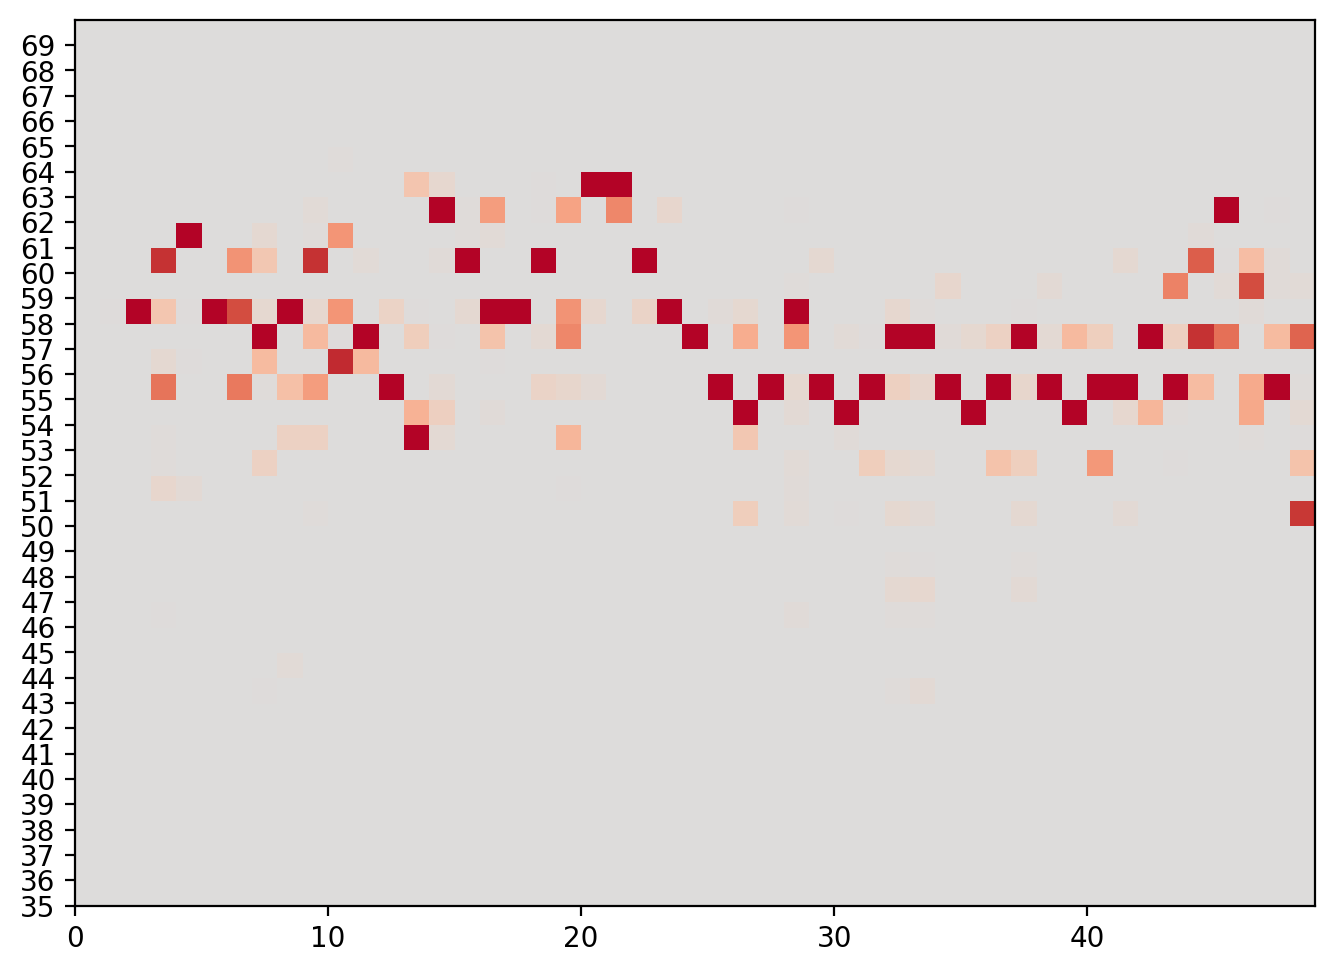

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

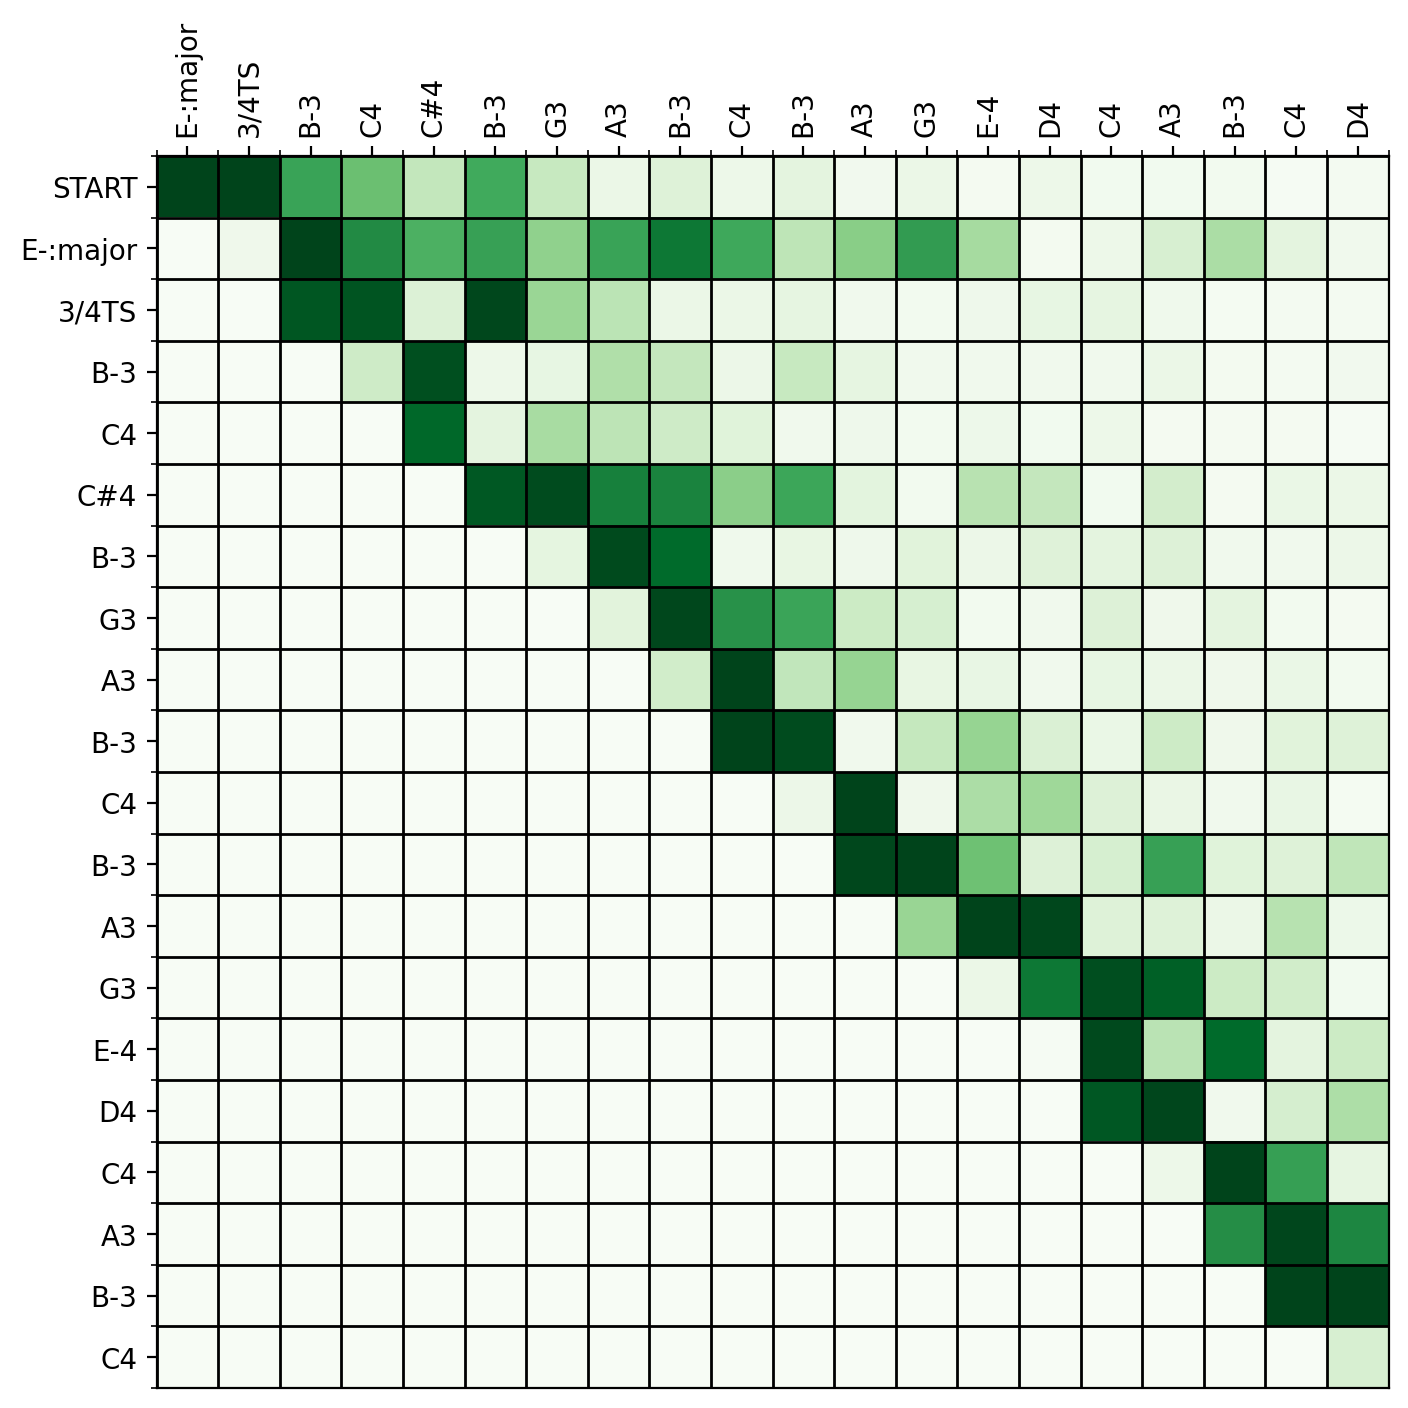

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()


In [ ]:
from google.colab import files
import shutil

shutil.make_archive("/content/model", 'zip', "my_folder")
shutil.make_archive("/content/output", 'zip', "my_folder")
shutil.make_archive("/content/transformer_output", 'zip', "my_folder")
shutil.make_archive("/content/data", 'zip', "my_folder")

'/content/data.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Saving the model and its data on the Google drive

!cp -r /content/data /content/drive/MyDrive/GenAI
!cp -r /content/model /content/drive/MyDrive/GenAI
!cp -r /content/output /content/drive/MyDrive/GenAI
!cp -r /content/transformer_output /content/drive/MyDrive/GenAI